## RNN ile Havayolu Yolcu Sayısı Tahmini

1) İş Problemi (Business Problem)

2) Veriyi Anlamak (Data Understanding)

3) Veriyi Hazırlamak (Data Preparation)

4) Modelleme (Modeling)

5) Değerlendirme (Evaluation)

### 1) İş Problemi (Business Problem)

Geçmiş verileri verilen havayolu bilgilerini kullanarak gelecek yolcu sayısı tahmini.

- **Month:** Aylık olarak yer alan tarih değişkenidir.
- **Passengers:** İlgili işlem tarihindeki yolcu sayısını, yani aylık yolcu sayısını temsil etmektedir.

- **Veri Seti:** [Kaggle](https://www.kaggle.com/andreazzini/international-airline-passengers)

### 2) Veriyi Anlamak (Data Understanding)

#### 2.1) Gerekli Kütüphanelerin Import İşlemleri

In [1]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılacak olan kütüphaneler
import warnings
warnings.filterwarnings("ignore")

# Tensorflow warning engellemek için kullanılacak olan kütüphaneler
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#### 2.2) Veri Setini Yüklenmesi ve Verinin Genel Resminin İncelenmesi

In [2]:
df = pd.read_csv("international-airline-passengers.csv")

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [5]:
df.columns = ["Month", "Passengers"]

In [6]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [7]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [8]:
df.shape

(145, 2)

In [9]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [10]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


### 3) Veriyi Hazırlamak (Data Preparation)

In [12]:
df = df[:144]

In [13]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [15]:
df["Month"] = pd.to_datetime(df["Month"])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [17]:
print("Minimum Tarih:", df["Month"].min())
print("Maximum Tarih:", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maximum Tarih: 1960-12-01 00:00:00


In [18]:
df.index = df["Month"]
df.drop(columns="Month", axis=1, inplace=True)

In [19]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [20]:
result_df = df.copy()

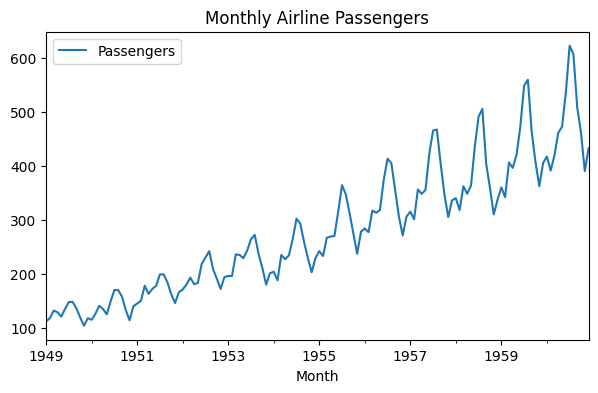

In [21]:
df.plot(figsize=(7,4), title="Monthly Airline Passengers");

In [22]:
data = df["Passengers"].values

In [23]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [24]:
type(data[0:5])

numpy.ndarray

In [25]:
type(data[0])

numpy.float64

In [26]:
data = data.astype("float32")

In [27]:
type(data[0])

numpy.float32

In [28]:
data.shape

(144,)

In [29]:
data = data.reshape(-1,1)

In [30]:
data.shape

(144, 1)

In [31]:
# Zaman serilerinde zamansallık bozulacağı için random bir şekilde train_test_split yapamıyoruz bu yüzden aşağıdaki gibi bir fonksiyon tanımladık.

def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [32]:
train, test, position = split_data(data, 0.33)

In [33]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [34]:
# Data leakage olmaması için train ve test setlerini ayrı ayrı standartlaştırıyoruz.

In [35]:
scaler_train = MinMaxScaler(feature_range = (0, 1))

In [36]:
train = scaler_train.fit_transform(train)

In [37]:
scaler_test = MinMaxScaler(feature_range = (0, 1))

In [38]:
test = scaler_test.fit_transform(test)

In [39]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [40]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [41]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    
    return np.array(X), np.array(Y)

In [42]:
lookback = 1

In [43]:
# Train Veri Seti
X_train, y_train = create_features(train, lookback)

In [44]:
# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [45]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [46]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [47]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


### 4) Modelleme (Modeling)

In [48]:
model = Sequential()

model.add(SimpleRNN(units=50,
                   activation="relu",
                   input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

model.compile(loss="mean_squared_error", optimizer="adam")

In [51]:
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
            ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]

In [52]:
history = model.fit(x=X_train,
                   y=y_train,
                   epochs=100,
                   batch_size=1,
                   validation_data=(X_test, y_test),
                   callbacks=callbacks,
                   shuffle=False)

Epoch 1/100
 1/95 [..............................] - ETA: 17s - loss: 0.0030
Epoch 1: val_loss improved from inf to 0.03298, saving model to mymodel.h5
95/95 [==============================] - 0s 1ms/step - loss: 0.0476 - val_loss: 0.0330
Epoch 2/100
82/95 [========================>.....] - ETA: 0s - loss: 0.0239
Epoch 2: val_loss improved from 0.03298 to 0.03047, saving model to mymodel.h5
95/95 [==============================] - 0s 825us/step - loss: 0.0316 - val_loss: 0.0305
Epoch 3/100
 1/95 [..............................] - ETA: 0s - loss: 0.0692
Epoch 3: val_loss improved from 0.03047 to 0.02796, saving model to mymodel.h5
95/95 [==============================] - 0s 544us/step - loss: 0.0252 - val_loss: 0.0280
Epoch 4/100
 1/95 [..............................] - ETA: 0s - loss: 0.0564
Epoch 4: val_loss improved from 0.02796 to 0.02615, saving model to mymodel.h5
95/95 [==============================] - 0s 574us/step - loss: 0.0235 - val_loss: 0.0262
Epoch 5/100
 1/95 [..........

### 5) Değerlendirme (Evaluation)

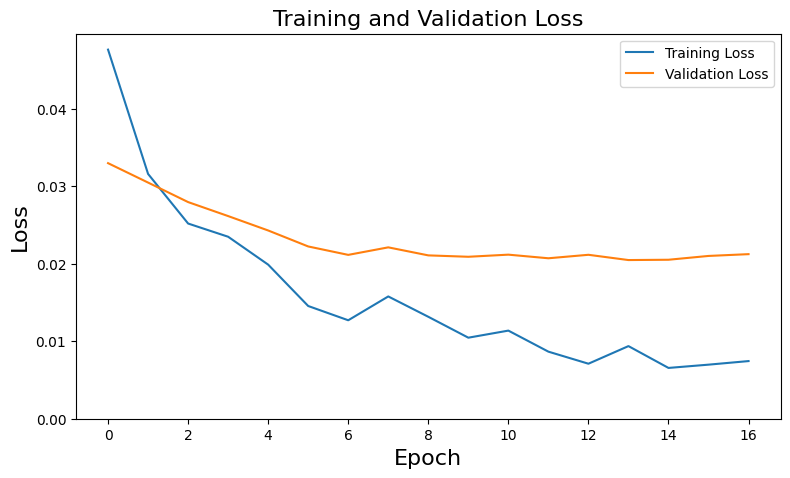

In [53]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

In [54]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest Loss: %.1f%%" % (100.0 * loss))

47/47 [==============================] - 0s 333us/step - loss: 0.0212

Test Loss: 2.1%


In [55]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 1ms/step


In [56]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [57]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [58]:
# Train Veri Setine Ait RMSE Değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [59]:
# Test Veri Setine Ait RMSE Değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [60]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 23.728437423706055
Test RMSE: 46.77840805053711


In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [62]:
train_prediction = result_df[lookback:position]

In [63]:
train_prediction["Predicted"] = train_predict

In [64]:
train_prediction.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,133.829895
1949-03-01,132.0,135.646637
1949-04-01,129.0,145.948761
1949-05-01,121.0,143.273636
1949-06-01,135.0,137.366257


In [65]:
test_prediction = result_df[position+lookback:]
test_prediction["Predicted"] = test_predict
test_prediction.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,333.660461
1957-03-01,356.0,330.814911
1957-04-01,348.0,368.391083
1957-05-01,355.0,361.039246
1957-06-01,422.0,367.472137


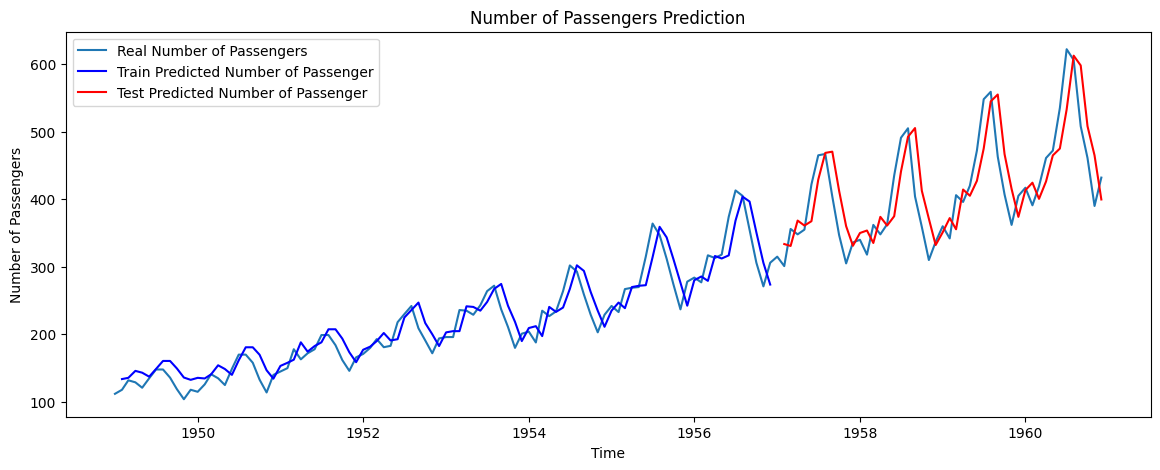

In [66]:
# Train ve Test Tahminlerini Ayrı Ayrı Görselleştirme İşlemi
plt.figure(figsize=(14,5))
plt.plot(result_df, label = "Real Number of Passengers")
plt.plot(train_prediction["Predicted"], color = "blue", label = "Train Predicted Number of Passenger")
plt.plot(test_prediction["Predicted"], color = "red", label = "Test Predicted Number of Passenger")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()